## Refunders Basic Tests

### Imports and Globals

In [160]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
# from ds_utils.utils.set_env import set_ds_env
# from ds_utils.utils.spark_helpers import get_spark_conf, get_spark_context

# set_ds_env()

# from pyspark import SparkConf, SparkContext
# from pyspark.sql import functions as F
# from pyspark.sql import HiveContext, SparkSession

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV, 
                                     StratifiedKFold, 
                                     cross_val_score, 
                                     train_test_split)

# from ds_etl.data_sources.admin_tool import AdminTool

In [2]:
SMALL_SIZE  = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

FIGSIZE_TWO_PLOTS = (10, 6)
FIGSIZE_ONE_PLOT  = (8, 6)

In [3]:
VIKINGS_FACT_TABLE = 'vikings.fact_vikings_krd_1_'
VIKINGS_DIM_DICT   = 'vikings.dim_krd_1'
FEATURES_TABLE     = 'vikings_trans.features_all'

SINCE_DATE = '2016-01-01'
LAST_DATE  = '2018-10-10'
SINCE_GOOD_DATE = '2017-01-01'
THRESHOLD_PCT = 60

In [5]:
# if 'sc' in locals():
#     sc.stop()
# if 'spark' in locals():
#     spark.stop()
    
# conf = SparkConf().setMaster("yarn").setAll([
#     ('spark.app.name', 'tmp_notebook'),
#     ('spark.executor.cores', '1'),
#     ('spark.executor.memory', '1g'),
#     ('spark.driver.memory', '32g'),
#     ('spark.dynamicAllocation.maxExecutors', '80'),
#     ('spark.dynamicAllocation.enabled', 'true'),
#     ('spark.shuffle.service.enabled', 'true'),
#     ('spark.driver.maxResultSize', '32g'),
#     ('spark.sql.hive.convertMetastoreOrc', 'false')
# ])

# sc = SparkContext(conf=conf)
# sqlContext = HiveContext(sc)
# spark = SparkSession(sc)

### Utils

#### get_dim_dict

In [5]:
# def get_dim_dict():
#     return spark.sql('select * from {}'.format(VIKINGS_DIM_DICT)).toPandas()

#### ensure_refund_offers

In [6]:
def ensure_refund_offers(since):
    fpath = 'refund_offers_{0}.csv'.format(since)
    return pd.read_csv(fpath)

#### ensure_refunds

In [7]:
def ensure_refunds(since):
    fpath = 'refunds_{0}.csv'.format(since)
    return pd.read_csv(fpath, parse_dates=['date'])

#### ensure_transactions

In [8]:
def ensure_transactions(since):
    fpath = 'transactions_{0}.csv'.format(since)
    return pd.read_csv(fpath, parse_dates=['date'])

#### ensure_good_payment_history

In [9]:
def ensure_good_payment_history(since, limit):
    fpath = 'good_payment_history_{0}_{1}.csv'.format(since, limit)
    pay_df = pd.read_csv(fpath, parse_dates=['date']).reset_index(drop=True)
    agg_df = get_agg(pay_df).reset_index(drop=True)
    return pay_df, agg_df

#### ensure_payment_history

In [10]:
def ensure_payment_history(since):
    fpath = 'payment_history_{0}.csv'.format(since)
    pay_df = pd.read_csv(fpath, parse_dates=['date']).reset_index(drop=True)
    agg_df = get_agg(pay_df).reset_index(drop=True)
    return pay_df, agg_df

#### get_agg

In [89]:
def get_agg(df):
    refunds_df = df[df['type'] == 1]
    trans_df = df[df['type'] == 0]

    if len(refunds_df) == 0:
        agg_df = trans_df.groupby('userid').agg({'value': 'sum'})
        agg_df['refund'] = 0.0
        agg_df.rename(columns={'value': 'spent'}, inplace=True)
        agg_df.index.name = None
        agg_df['userid'] = agg_df.index.values.astype(int)
    else:
        tdf = trans_df.groupby('userid').agg({'value': 'sum'})
        tdf.index.name = None
        tdf['userid'] = tdf.index.values.astype(int)
        rdf = refunds_df.groupby('userid').agg({'value': 'sum'})
        rdf.index.name = None
        rdf['userid'] = rdf.index.values.astype(int)
        agg_df = pd.merge(tdf, rdf, on='userid', how='left').fillna(0.0)
        agg_df.columns = ['spent', 'userid', 'refund']
        
    agg_df['pct'] = 100 * agg_df['refund'] / agg_df['spent']
    agg_df['userid'] = agg_df['userid'].astype(int)

    stat_df = pd.read_csv('login_stats.csv', parse_dates=['first_login', 'last_login'])
    stat_df['userid'] = stat_df['userid'].astype(int)
    # todo: other stats...
    
    agg_df = pd.merge(agg_df, stat_df,
                      on='userid',
                      how='left')

    return agg_df

#### normalize_user_dates

In [12]:
def normalize_user_dates(user_df, from_date, to_date):
    user_id = user_df['userid'].values[0]
    min_date = from_date
    max_date = max(to_date, user_df['date'].max())
    dates = list(pd.date_range(min_date, max_date))

    user_df = user_df[(min_date <= user_df['date']) &
                      (user_df['date'] <= max_date)]

    norm_df = pd.DataFrame({'date': dates})
    norm_df = pd.merge(norm_df, user_df, on='date', how='left', sort=True)
    norm_df.fillna(0, inplace=True)
    norm_df['userid'] = user_id
    norm_df['type'] = norm_df['type'].astype(int)
    norm_df['cnt'] = norm_df['cnt'].astype(int)

    return norm_df

#### ensure_login_stats

#### visualize_pay_history

In [14]:
def visualize_pay_history(user_df, user_ag, axis, title):
    user_id = user_df['userid'].values[0]
    norm_df = normalize_user_dates(user_df, user_ag['first_login'], user_ag['last_login'])

    x = norm_df['date'].values
    y = norm_df['value']*(1 - 2*norm_df['type']).values

    axis.plot(x, y)
        
    axis.grid(True)
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    axis.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axis.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    axis.set_title('{0} ({1})'.format(user_id, title))

#### DTW

In [203]:
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist

def dtw(x, y, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """

    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf

    D1 = D0[1:, 1:]  # view
    
    for i in range(r):
        for j in range(c):
            D1[i, j] = abs(x[i] - y[j])
    C = D1.copy()

    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)

    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)

    return D1[-1, -1] / sum(D1.shape), C, D1, path


def accelerated_dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x) == 1:
        x = x.reshape(-1, 1)
    if ndim(y) == 1:
        y = y.reshape(-1, 1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:, 1:] = cdist(x, y, dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                min_list += [D0[min(i + k, r - 1), j],
                             D0[i, min(j + k, c - 1)]]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path


def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [16]:
from sklearn.base import BaseEstimator, ClusterMixin

class SimpleClusterizer(BaseEstimator, ClusterMixin):
    def __init__(self, dist, random_state=None):
        self.dist = dist
        self.random_state = random_state
        self._labels = None
        self._clusters = None


    def fit(self, X, y):
        labels = np.unique(y[y != np.array(None)])

        clusters = { l: list(X[y==l]) for l in labels }

        X_unm = X[y==None]
        np.random.seed(self.random_state)
        np.random.shuffle(X_unm)

        self.log = []

        for x in X_unm:
            label = None
            dist = np.inf
            for l in labels:
                cluster = clusters[l]
                d = self._get_dist(x, cluster)
                if d < dist:
                    dist = d
                    label = l
            clusters[label].append(x)
            self.log.append(x)

        self._clusters = clusters
        self._labels = labels


    def predict(self, X):
        y = []
        for x in X:
            label = None
            dist = np.inf
            for l in self._labels:
                cluster = self._clusters[l]
                d = self._get_dist(x, cluster)
                if d < dist:
                    dist = d
                    label = l
            y.append(label)
        return y


    def _get_dist(self, x, cluster):
        dist = np.inf
        for xc in cluster:
            d = self.dist(x, xc)
            if d < dist:
                dist = d
        #dist = np.array([self.dist(x, xc) for xc in cluster]).mean()
        return dist

### Good users to compare with

In [90]:
gpay_df, gagg_df = ensure_good_payment_history(SINCE_DATE, 100000)
gpay_df.shape

(1269947, 5)

In [91]:
gagg_df.head()

,spent,refund,userid,pct,first_login,last_login,total_logins
0,1235.62,0.0,3,0.0,2015-07-30,2018-01-13,1003.0
1,82.78,0.0,113,0.0,2015-07-30,2017-04-28,11738.0
2,4.99,0.0,986,0.0,2015-08-17,2016-05-29,38.0
3,144.80,0.0,1377,0.0,2016-07-01,2016-11-24,3617.0
4,2635.80,0.0,1556,0.0,2015-07-30,2018-10-12,39839.0


In [92]:
gagg_df = gagg_df.sort_values('spent', ascending=False).reset_index(drop=True)
gagg_df.head()

,spent,refund,userid,pct,first_login,last_login,total_logins
0,133016.87,0.0,3237794,0.0,2015-12-27,2018-10-12,35227.0
1,126834.94,0.0,15929482,0.0,2017-03-12,2018-10-12,30733.0
2,110151.25,0.0,23865087,0.0,2017-12-02,2018-10-12,20410.0
3,105997.60,0.0,1301952,0.0,2015-09-29,2018-10-12,29452.0
4,97817.13,0.0,15229821,0.0,2017-02-21,2018-10-12,50730.0


### Refunders

In [93]:
pay_df, agg_df = ensure_payment_history(SINCE_DATE)

print('total refunders: ', len(agg_df))

agg_df.head()

total refunders:  7992


,spent,userid,refund,pct,first_login,last_login,total_logins
0,4803.15,8604,349.96,7.286052,2015-07-30,2018-10-12,48791
1,9.98,9776,9.98,100.000000,2015-08-12,2016-09-29,4016
2,10297.71,18472,99.99,0.970993,2015-07-30,2018-07-16,46586
3,89999.74,20988,1099.89,1.222104,2015-07-30,2018-10-12,105000
4,5562.22,22381,49.99,0.898742,2015-07-31,2018-10-12,50361


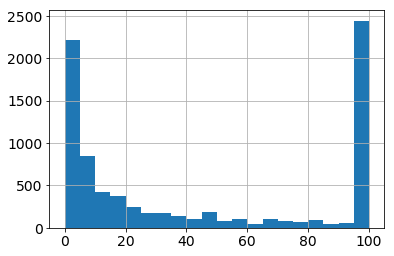

In [94]:
agg_df['pct'].hist(bins=20)
plt.show()

In [95]:
for i in range(11):
    min_pct = i*10
    max_pct = (i+1)*10
    print('{}-{}%\t\t{}'.format(min_pct, max_pct, 
                              agg_df[(min_pct <= agg_df['pct']) & (agg_df['pct'] < max_pct)].shape[0]))
    
print(agg_df[(50 <= agg_df['pct'])].shape)

0-10%		3055
10-20%		788
20-30%		434
30-40%		289
40-50%		209
50-60%		277
60-70%		154
70-80%		140
80-90%		149
90-100%		186
100-110%		2311
(3217, 7)


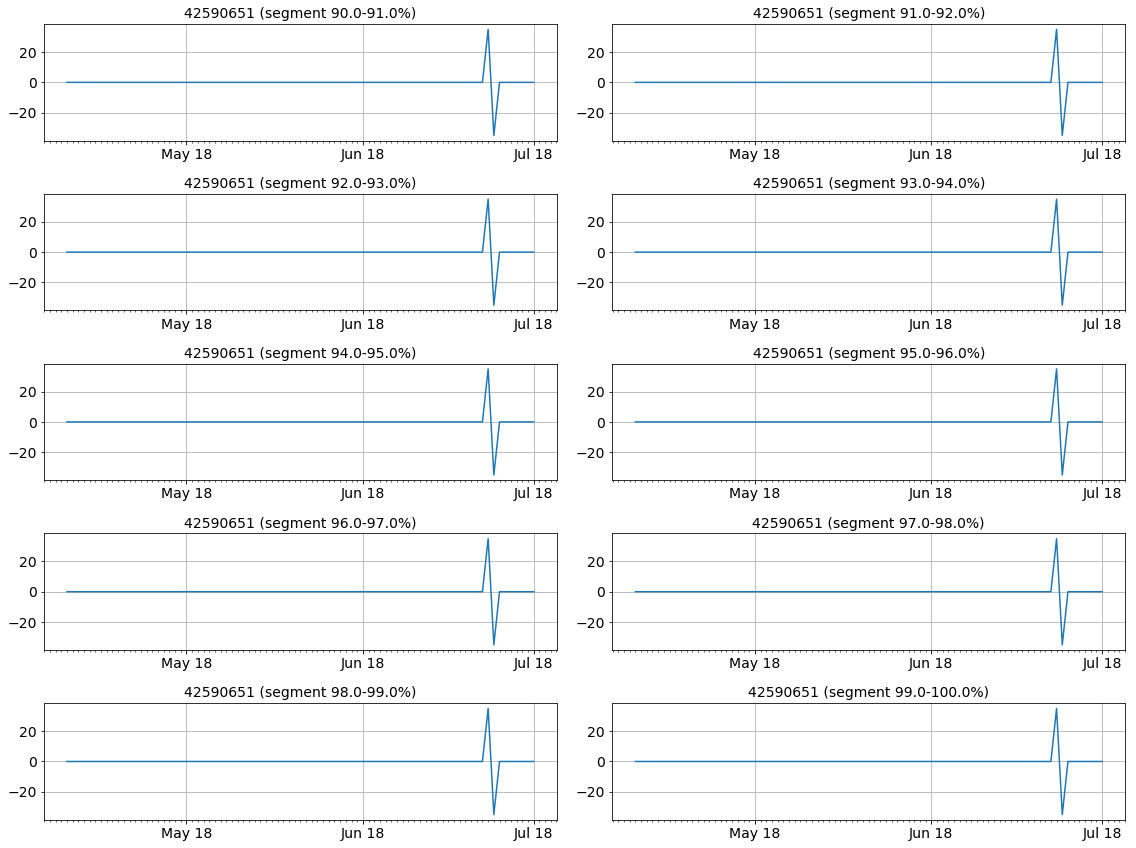

In [106]:
fig, axes = plt.subplots(5, 2, figsize=(16, 12))
smin = 90
smax = 100
segms = [smin + (smax - smin)*i/10 for i in range(11)]

for i in range(10):
    segm_users = agg_df[(segms[i] < agg_df['pct']) & (agg_df['pct'] <= segms[i+1])]\
                 .sort_values('spent', ascending=False)['userid']\
                 .values
    
    user_id = 42590651 #segm_users[0]
    user_df = pay_df[pay_df['userid'] == user_id]
    user_ag = agg_df[agg_df['userid'] == user_id].iloc[0, :]

    axis = axes[i//2, i%2]
    title = 'segment {0}-{1}%'.format(segms[i], segms[i+1])
    
    visualize_pay_history(user_df, user_ag, axis, title)

plt.tight_layout()
plt.show()

### Clustering

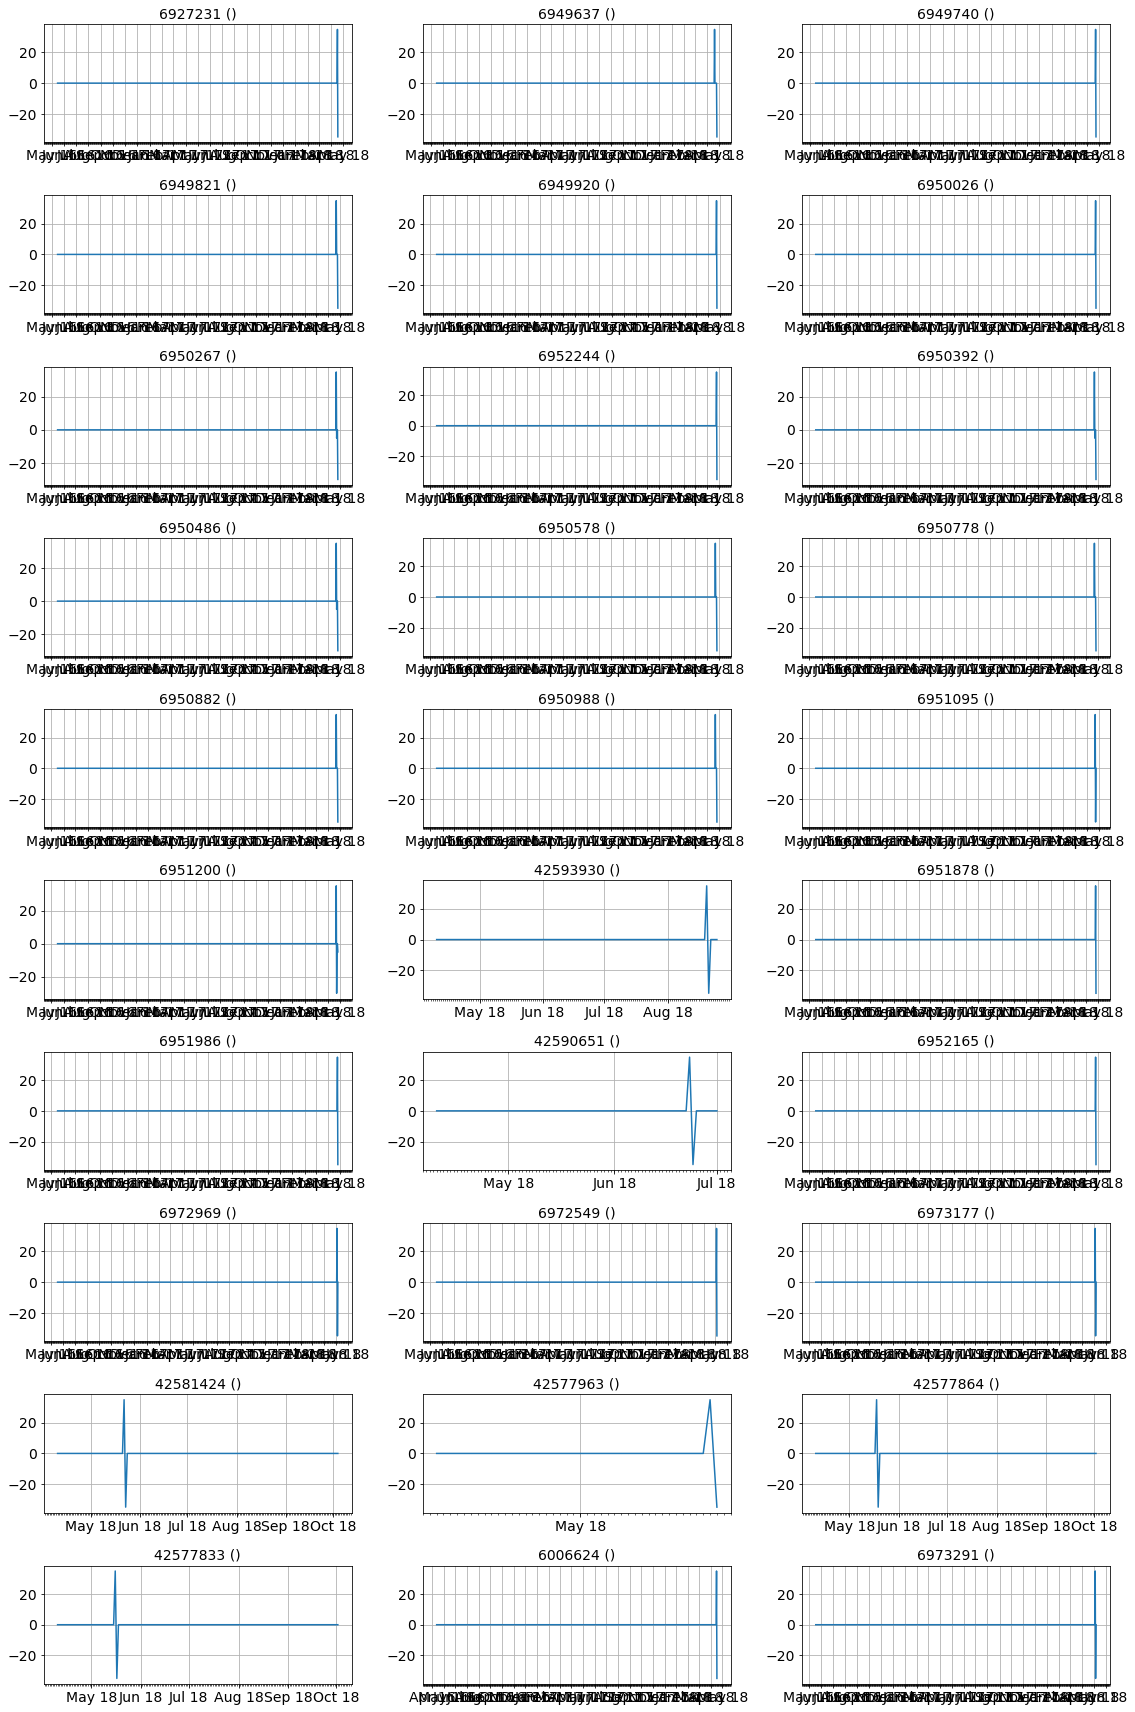

In [97]:
fig, axes = plt.subplots(10, 3, figsize=(16, 24))
user_ids = agg_df[agg_df['pct'] == 100].sort_values('spent', ascending=False)['userid'].values

for i in range(30):
    user_id = user_ids[500+i]
    user_df = pay_df[pay_df['userid'] == user_id]
    user_ag = agg_df[agg_df['userid'] == user_id].iloc[0, :]

    axis = axes[i//3, i%3]
    
    visualize_pay_history(user_df, user_ag, axis, '')

plt.tight_layout()
plt.show()

## DTW


In [98]:
def get_clust_features(pays, aggs):
    feats = []

    user_ids = pays['userid'].unique()
    for user_id in user_ids:
        user_df = pays[pays['userid'] == user_id]
        user_ag = aggs[aggs['userid'] == user_id]
        if len(user_ag) == 0:  # WARNING: 39018652 have no trans in Hive, but 1 tran (with refund) in comtool
            continue
        user_ag = user_ag.iloc[0, :]
        
        fs = [user_id]
        
        # 1
        ch = np.abs(np.diff(user_df['type'].values)).sum()
        fs.append(ch)
        
        # 2
        fs.append(user_ag['pct'])
        
        # 3
        fs.append(user_df['type'].sum())
        
        feats.append(fs)

    feat_df = pd.DataFrame(feats, columns=['userid', 'ch', 'pct', 'rr'])
    return feat_df

In [99]:
clust_fs = get_clust_features(pay_df, agg_df)

In [123]:
np.random.seed(9)
cluster_ids = clust_fs[(clust_fs['pct'] == 100) & (clust_fs['ch'] == 1)]['userid'].values
np.random.shuffle(cluser_ids)

other_ids = pay_df['userid'].unique()
np.random.shuffle(other_ids)

In [124]:
pay_df['userid'].unique().shape

(7993,)

In [125]:
cluster_ids.shape

(2189,)

In [126]:
x = pay_df[pay_df['userid'] == 3594622]['value'].values.reshape(-1, 1)
y = pay_df[pay_df['userid'] == 46603522]['value'].values.reshape(-1, 1)

dtw(y, x, dist=lambda x, y: np.linalg.norm(x - y, ord=1))[0]

2.5099999999999989

In [239]:
def prepare_data():
    X = []
    y = []
    user_ids = pay_df['userid'].unique()
    for user_id in user_ids:
        user_df = pay_df[pay_df['userid'] == user_id]
        values = (user_df['value']*(1 - 2*user_df['type'])).values
        X.append(values)
        y.append(1 if user_id in cluster_ids else 0)
    
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=9) 

In [240]:
X_train, X_test, y_train, y_test = prepare_data()

In [241]:
y_clust = [None]*len(y_train)
y_clust[0] = 0
y_clust[4] = 1

In [242]:
def dist_function_modified(x, y):
    return dtw(x, y)[0]

model = SimpleClusterizer(dist_function_modified, random_state=9)
model.fit(np.array(X_train)[:200], np.array(y_clust)[:200])

In [243]:
y_pred = model.predict(X_test[:200])

In [244]:
precision = precision_score(y_test[:200], y_pred)
recall = recall_score(y_test[:200], y_pred)
f1 = f1_score(y_test[:200], y_pred)

print(precision, recall, f1)

0.298245614035 0.68 0.414634146341


In [245]:
def dist_function_modified(x, y):
    k = y.max()/x.max()
    x = k*x
    return dtw(x, y)[0]

model = SimpleClusterizer(dist_function_modified, random_state=9)
model.fit(np.array(X_train)[:200], np.array(y_clust)[:200])

In [246]:
y_pred = model.predict(X_test[:200])

In [247]:
precision = precision_score(y_test[:200], y_pred)
recall = recall_score(y_test[:200], y_pred)
f1 = f1_score(y_test[:200], y_pred)

print(precision, recall, f1)

0.25 1.0 0.4


In [248]:
def dist_function_modified(x, y):
    k1 = y.max()/x.max()
    k2 = y.min()/x.min()

    x[np.where(x > 0)] *= k1
    x[np.where(x < 0)] *= k2

    return dtw(x, y)[0]

model = SimpleClusterizer(dist_function_modified, random_state=9)
model.fit(np.array(X_train)[:200], np.array(y_clust)[:200])

In [249]:
y_pred = model.predict(X_test[:200])

In [250]:
precision = precision_score(y_test[:200], y_pred)
recall = recall_score(y_test[:200], y_pred)
f1 = f1_score(y_test[:200], y_pred)

print(precision, recall, f1)

0.716417910448 0.96 0.820512820513


### Basic feature extraction

In [44]:
def extract_features(user_df, user_ag, part=False):
    user_id = user_df['userid'].values[0]
    
    fs = [user_id]
    
    first_login = user_ag['first_login']
    last_login  = user_df.iloc[-1]['date'] if part else user_ag['last_login']

    # f1: user lifetime
    L = (last_login - first_login).days + 1
    fs.append(L)

    # f2: delta_1
    d1 = (user_df.iloc[0]['date'] - first_login).days
    fs.append(d1)

    # f3: delta_2
    d2 = (last_login - user_df.iloc[-1]['date']).days
    fs.append(d2)

    # f4: current pct
    p1 = user_df[user_df['type'] == 1]['value']
    p1 = p1.sum() if len(p1)>0 else 0.0
    p2 = user_df[user_df['type'] == 0]['value']
    p2 = p2.sum() if len(p2)>0 else 0.0
    pct = 0.0 if p2 == 0.0 else 100*p1/p2
    fs.append(pct)

    # f5: m1
    m1 = user_df[user_df['type'] == 0]['value']
    m1 = m1.mean() if len(m1)>0 else 0.0
    fs.append(m1)

    # f6: m2
    m2 = user_df[user_df['type'] == 1]['value']
    m2 = m2.mean() if len(m2)>0 else 0.0
    fs.append(m2)

    # f7: m1/m2
    m1dm2 = m1/(m2 + 0.01)
    fs.append(m1dm2)

    # f8: m3
    m3 = user_df[user_df['type'] == 0]['value']
    m3 = m3.max() if len(m3)>0 else 0.0
    fs.append(m3)

    # f9: m4
    m4 = user_df[user_df['type'] == 1]['value']
    m4 = m4.max() if len(m4)>0 else 0.0
    fs.append(m4)

    # f10: m3/m4
    m3dm4 = m3/(m4 + 0.01)
    fs.append(m3dm4)

    # f11: chaotic (0, 1 - not chaotic, 0.5 - chaotic)
    ch = np.abs(np.diff(user_df['type'].values)).sum() / len(user_df)
    fs.append(ch)

    # f12: number of logins
    tl = user_ag['total_logins']
    fs.append(tl)
    
    return fs
 

def get_basic_features(pays, aggs, multiple=False, trunc_before_refund=False):
    feats = []

    user_ids = pays['userid'].unique()
    for user_id in user_ids:
        user_df = pays[pays['userid'] == user_id]
        user_ag = aggs[aggs['userid'] == user_id]
        if len(user_ag) == 0:  # WARNING: 39018652 have no trans in Hive, but 1 tran (with refund) in comtool
            continue
        user_ag = user_ag.iloc[0, :]
        
        part = False
        
        if trunc_before_refund:
            uparts_dfs = split_to_refunds(user_df)
            for upart_df in uparts_dfs:
                fs = extract_features(upart_df, user_ag, part=True)
                feats.append(fs)
        else:
            fs = extract_features(user_df, user_ag, part=False)
            feats.append(fs)

#         if multiple:
#             l = len(user_df)
            
#             l1 = int(0.3*l)
#             user_df1 = user_df.iloc[:l1, :]
#             if len(user_df1)>0:
#                 fs = extract_features(user_df1, user_ag, part=True)
#                 feats.append(fs)
                
#             l2 = int(0.6*l)
#             user_df2 = user_df.iloc[:l2, :]
#             if len(user_df2)>0:
#                 fs = extract_features(user_df2, user_ag, part=True)
#                 feats.append(fs)
            
#             l3 = int(0.9*l)
#             user_df3 = user_df.iloc[:l3, :]
#             if len(user_df3)>0:
#                 fs = extract_features(user_df3, user_ag, part=True)
#                 feats.append(fs)
#         else:
#             fs = extract_features(user_df, user_ag, part=part)
#             feats.append(fs)

    feat_df = pd.DataFrame(feats, columns=['userid',
                                           'L',
                                           'd1', 'd2',
                                           'cur_pct',
                                           'm1', 'm2', 'm1dm2', 'm3', 'm4', 'm3dm4',
                                           'ch',
                                           'tl'])
    return feat_df


def split_to_refunds(user_df):
    l = len(user_df)
    ts = user_df['type'].values
    refs = np.where(ts == 1)[0]
    
    if len(refs) == 0:
        return [user_df]
    
    idx = max(int(0.9*refs[0]), 1)
    user_df = user_df.reset_index(drop=True).iloc[:idx, :]

    return [user_df]
    

def ensure_features(good_users, multiple, trunc_before_refund):
    fpath = 'features_good_{0}_{1}_{2}.csv'.format(good_users, 
                                                   'T' if multiple else 'F',
                                                   'T' if trunc_before_refund else 'F')
    if os.path.exists(fpath):
        return pd.read_csv(fpath)
    
    print('build features from bad users...')
    
    bad_df = get_basic_features(pay_df, agg_df, 
                                multiple=multiple, 
                                trunc_before_refund=trunc_before_refund)
    print(bad_df.shape)
    print(bad_df[bad_df['cur_pct'] >= THRESHOLD_PCT].shape)
    
    print('build features from good users...')
    
    good_ids = gagg_df.loc[:good_users, 'userid'].values
    good_df = gpay_df[gpay_df['userid'].isin(good_ids)]
    good_df = get_basic_features(good_df, gagg_df, 
                                 multiple=multiple, 
                                 trunc_before_refund=trunc_before_refund)
    
    feat_df = pd.concat([good_df, bad_df]).sample(frac=1, random_state=9)
    #feat_df = feat_df.drop(['userid', 'pct', 'cur_pct'], axis=1)
    
    feat_df.to_csv(fpath, index=False)

    return feat_df

## Model v.$\alpha$

In [56]:
gpay_df = gpay_df.reset_index(drop=True)
gagg_df = gagg_df.reset_index(drop=True)
pay_df = pay_df.reset_index(drop=True)
agg_df = agg_df.reset_index(drop=True)

feat_df = ensure_features(good_users=10000, multiple=False, trunc_before_refund=False)

In [61]:
feat_df.head(5)

,userid,L,d1,d2,cur_pct,m1,m2,m1dm2,m3,m4,m3dm4,ch,tl,target
0,42601507,142,139,1,100.000000,29.970000,29.97,0.999666,29.97,29.97,0.999666,0.500000,25.0,1
1,12189120,679,2,224,4.479451,10.378140,19.99,0.518907,39.95,19.99,1.997500,0.045455,19506.0,0
2,23296145,281,44,-1,50.000000,9.990000,9.99,0.999000,9.99,9.99,0.999000,0.333333,64.0,0
3,13133396,19,4,2,42.873497,6.988000,7.49,0.931733,9.99,9.99,0.999000,0.428571,1498.0,0
4,42556428,187,0,2,0.000000,40.991111,0.00,4099.111111,199.98,0.00,19998.000000,0.000000,8981.0,0


In [58]:
feat_df['target'] = (pd.merge(feat_df, agg_df, on='userid', how='left').fillna(0.0)['pct'] > THRESHOLD_PCT).astype(int)

In [59]:
feat_df['target'].value_counts()

0    15058
1     2935
Name: target, dtype: int64

In [60]:
def train_model(df, estimator, params):
    """Trains selected model"""
    
    X = df.drop('target', axis=1)
    y = df['target']
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.5, stratify=y, random_state=9)

    pipeline = Pipeline(steps=[
        ('scaling', StandardScaler()),
        ('model',   estimator)
    ])
    
    cv = StratifiedKFold(n_splits=9, shuffle=True, random_state=9)
    grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    cv_score = grid.best_score_
    
    y_pred = best_model.predict_proba(X_test)[:, 1]
    
    ho_score = roc_auc_score(y_test, y_pred)

    return best_model, cv_score, ho_score

In [62]:
model = RandomForestClassifier(n_estimators=1, random_state=9)
model, cv_score, ho_score = train_model(feat_df.drop(['userid', 'cur_pct'], axis=1), model, {})

print(cv_score, ho_score)

0.9306880351111622 0.9440746913930983


In [31]:
rf = model.named_steps['model']
rf.feature_importances_

array([0.12939576, 0.10242869, 0.13519479, 0.11873798, 0.02437229,
       0.10395393, 0.08781515, 0.02658407, 0.0841904 , 0.02626739,
       0.16105954])

In [32]:
feat_df.columns

Index(['userid', 'L', 'd1', 'd2', 'cur_pct', 'm1', 'm2', 'm1dm2', 'm3', 'm4',
       'm3dm4', 'ch', 'tl', 'pct', 'target'],
      dtype='object')

In [33]:
X = data_df.drop('target', axis=1)
y = data_df['target']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, stratify=y, random_state=9)

model = RandomForestClassifier(n_jobs=-1)
cv = StratifiedKFold(n_splits=9, shuffle=True, random_state=9)
cv_score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
print(cv_score)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
ho_score = roc_auc_score(y_test, y_pred)
print(ho_score)

NameError: name 'data_df' is not defined

Hard test

In [ ]:
init_bad_df = get_basic_features(pay_df, agg_df, multiple=False)\
                 .drop('userid', axis=1)\
                 .sample(frac=1, random_state=9)
         
init_bad_df['target'] = (init_bad_df['pct'] > THRESHOLD).astype(int)
init_bad_df = init_bad_df.drop('pct', axis=1)

In [ ]:
init_bad_df.head()

In [ ]:
X_hard = init_bad_df.drop('target', axis=1)
y_hard = init_bad_df['target']

y_pred = model.predict_proba(X_hard)[:, 1]

h_score = roc_auc_score(y_hard, y_pred)
h_score

In [ ]:
y_pred = (y_pred > THRESHOLD).astype(int)

In [ ]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


data = scale(feat_df)
pca = PCA(n_components=2).fit(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=2)
kmeans.fit(data)

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('{} {} {} {}'
          .format(name, (time() - t0), estimator.inertia_,
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=len(feat_df))))

bench_k_means(KMeans(init='k-means++', n_clusters=2, n_init=2),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=2, n_init=2),
              name="random", data=data)


# visualization

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=2)
kmeans.fit(reduced_data)

print(pca.explained_variance_ratio_)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
# from ds_utils.utils.spark_helpers import get_spark_context
# from ds_etl.data_sources.admin_tool import AdminTool

# import pyspark as psp
# from pyspark.sql import SparkSession


# sc, sqlContext = get_spark_context()
# spark = SparkSession(sc)

